# Delta Hedging
### Thomas Polstra, PhD

##### [GitHub](https://github.com/thomaspolstra/Quant_Materials_Polstra_Public.git) -- [Academic Website](https://thomaspolstra.github.io/) -- [Email](mailto:thomaspolstra@gmail.com)

### Purpose of the Notebook

Demonstrate that dynamic delta hedging has an intriguing characteristic: dynamic delta hedging has a tendency to generate profit distributions that exhibit a normal distribution. This unique property has profound implications for understanding the behavior of profits in response to market fluctuations.

**Delta Hedging**

Delta hedging is a risk management strategy used in financial markets, particularly in options trading, to reduce or eliminate the risk associated with changes in the price of the underlying asset. The strategy involves adjusting the portfolio of options and their underlying assets in a way that offsets the changes in value due to small price movements in the underlying asset.

The "delta" in delta hedging refers to the sensitivity of an option's price to changes in the price of the underlying asset. Delta is a measure of how much the option's value will change for a small change in the price of the underlying asset. By continuously adjusting the portfolio to maintain a neutral overall delta, traders aim to mitigate the impact of value fluctuations on their overall position relative to the underlying.

In practice, delta hedging involves the following steps:

1. **Initial Position**: A trader starts with a position that includes both options (calls or puts) and their corresponding underlying assets.

2. **Calculate Delta**: The trader calculates the delta of each option in the portfolio. Delta can be positive (for call options) or negative (for put options) and ranges from -1 to 1.

3. **Adjustments**: As the price of the underlying asset changes, the trader makes adjustments to the portfolio by buying or selling additional options or the underlying asset to maintain a neutral overall delta. This ensures that the changes in the option's value offset changes in the underlying asset's value.

4. **Rebalancing**: Delta hedging requires periodic rebalancing to account for changes in the delta due to price movements. The frequency of rebalancing depends on the trading strategy and the desired level of risk management.

Delta hedging allows traders to lock in profits or minimize losses that arise from small price fluctuations in the underlying asset. However, it's important to note that delta hedging does not eliminate all risks, particularly in the presence of larger price movements or changes in implied volatility.

Overall, delta hedging is a practical approach for managing risk and ensuring a more stable financial position in options trading by adjusting the portfolio to counteract the impact of market price changes.

**A remark about expected profits**
We are going to study the distributions of profits of a buy and hold strategy, a statically hedged strategy, and a dynamically hedged strategy. We will price all options at Black-Scholes price of a European option. Consequently, all of our strategies will have an expected profit of $0$. We point this out as trading strategies, no matter how much they mitigate risk, are profitable when purchased or sold assets/contracts are underpriced are overpriced accordingly.

In [1]:
%run Preamble_Hedging.py

**Profit distributions of buy and hold**
Let's consider a Monte-Carlo simulation of a stock movement which is a Geometric Brownian motion. We will then plot the return distributions of purchasing $50$ of the underlying asset.

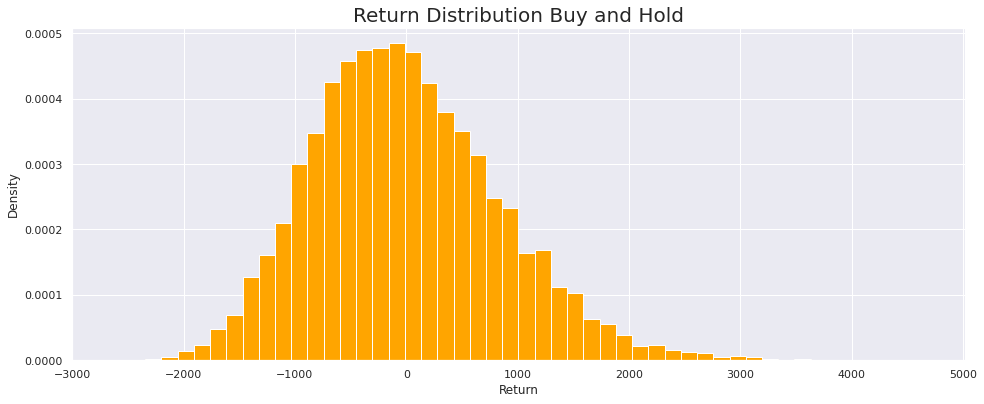

In [2]:
K = 102  # Strike price
DTE = 75  # Days to expiration
N = int(DTE / 5)  # Number of time steps (weeks)
sigma = 0.30  # Volatility
S0 = 102  # Initial stock price
T = DTE / 252  # Time to expiration in years
r = 0  # Risk-free rate

DT = T / N  # Time interval between steps
TTE = [DT * N - DT * i for i in range(0, N + 1)]  # Time to expiration at each step

# Simulate asset price paths
A = geo_paths(S0,T,sigma,16,K,10000)

returns = A[-1] - A[0]  # Calculate the returns
plt.hist(50 * returns, density=True, bins=50, color='orange')  # Plot histogram
plt.title('Return Distribution Buy and Hold', size=20)  # Set plot title
plt.xlabel('Return', size=12)  # Set x-axis label
plt.ylabel('Density', size=12)  # Set y-axis label
plt.show()  # Display the plot


The profit distribution of the buy and hold approach is suboptimal. It follows a normal distribution with its center at 0. Engaging in buy and hold strategies without thorough market research is not a feasible approach.

In [3]:
print(f'The expected return of buy and hold of 50 stocks is {round(np.mean(50*(A[1]-K)/K)-1,2)}%')

The expected return of buy and hold of 50 stocks is -1.04%


**Profit Distribution of a Put**
Now let's look at the profit distribution of purchasing $100$ puts on the underlying when priced at the Black-Scholes European option price.

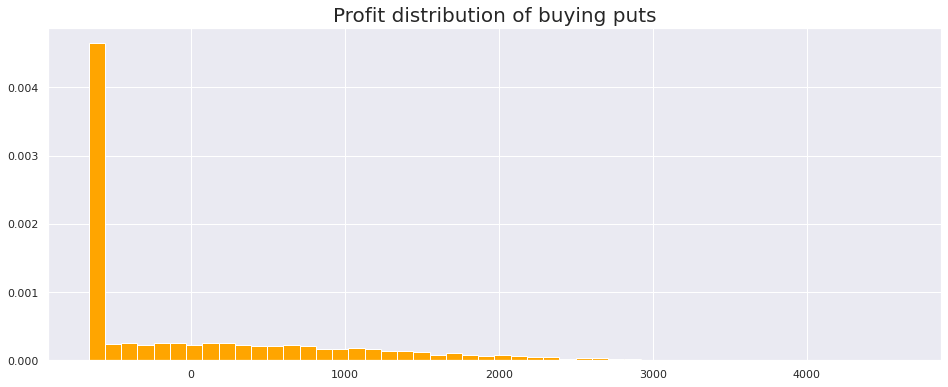

In [4]:
# Calculate option price using Black-Scholes formula for a put option
option_price = bs('p', K, K, T, r, sigma)

# Calculate the payoffs for buying puts
B = np.maximum(-(A[-1] - K), 0) - option_price

# Plot the profit distribution of buying puts
plt.hist(100 * B, density=True, bins=50, color='orange')
plt.title('Profit distribution of buying puts', size=20)
plt.show()


In [5]:
print(f'The expected return of purchasing 100 puts {round(np.mean(100*returns/K)-1,2)}%')
print('-----------')

The expected return of purchasing 100 puts -1.14%
-----------


The profit distrbution of a put are heavily weighted towards the loss. Therefore the 'WallStreetBets' strategy of putting an entrie life savings into a single option contract can have great reward, but also is very likely to lead to significant and consistent losses!

**Static Hedging**

Let's now examine the profit distribution of a statically hedged put strategy. It's important to remember that the primary objective of a hedge is to offset changes in the value of a position due to fluctuations in the underlying asset's price. When it comes to the strike price, a put option demonstrates a delta of -$0.5$ concerning the underlying asset. This implies that for each $1$ unit change in the underlying's price, the value of the put option would decrease by $0.5$ units. To effectively hedge a portfolio of 100 put contracts, it would be necessary to acquire 50 units of the underlying asset. To illustrate, the graph below represents the profit and loss dynamics of a delta-hedged put contract. The contract is priced according to the Black-Scholes model's European put option pricing formula.

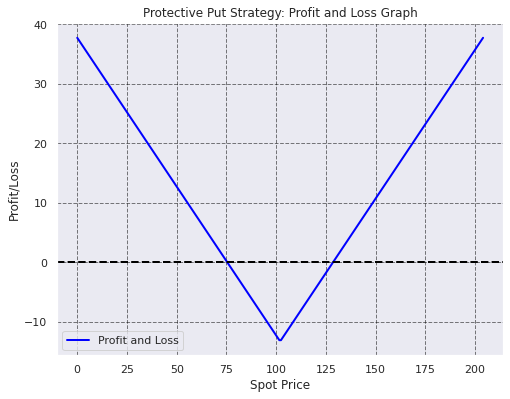

In [6]:
spot_prices = np.linspace(0, 2*K, 250)
#Plot profit loss graph of protective put
protective_put_profit_loss_graph(spot_prices,K,K,option_price,0.5,1) 

**Profit distribution of a statically hedged put contract**

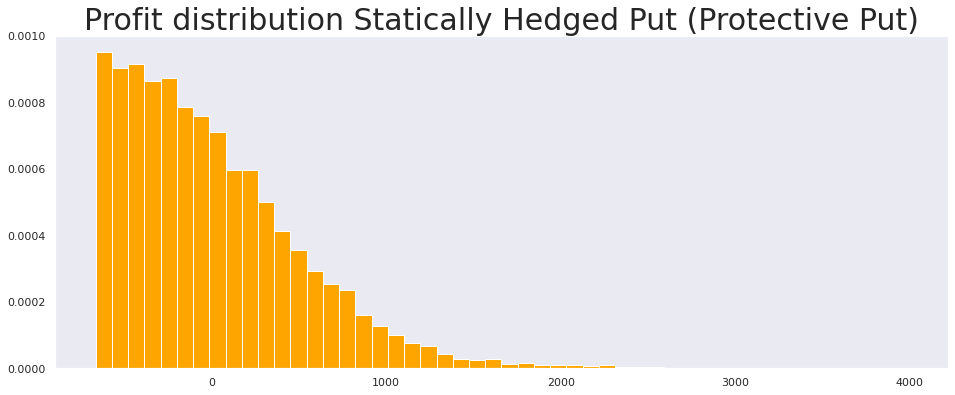

In [7]:
# Calculate the portfolio value for a protective put strategy
C = 100 * B + 50 * (A[-1] - K)

# Calculate the initial investment in the portfolio
money_in = 100 * option_price + 50 * K

# Plot the profit distribution of the statically hedged put (protective put) strategy
plt.hist(C, density=True, bins=50, color='orange')
plt.title('Profit distribution Statically Hedged Put (Protective Put)', size=30)
plt.show()


The profit distributions of a statically hedged put, also known as a protective put, exhibit a significant bias towards losses on the negative side of the $x$-axis, but not nearly as much as simply buying and holding an asset and therefore is a less risky investment strategy. However, as we transition to dynamic hedging, involving intermediate adjustments throughout the trading period, we will observe a transformation of the profit distribution towards a more balanced and normal distribution.

In [8]:
print(f'The expected return of buy and hold is {round(np.mean(100*C/money_in)-1,2)}%')
print('---------------')

The expected return of buy and hold is -0.95%
---------------


**Profit Distribution of a Dynamic Hedging Strategy**

To implement a dynamic hedging approach, we will make adjustments to our position at the conclusion of each trading week (taking into account the 5 trading days per week, spanning a total of 15 weeks in our example). Specifically, we will fine-tune our position by purchasing put options if our current delta is positive, and conversely, acquiring the underlying asset if our current delta is negative.

## Parameters for Delta Hedging Simulation

In the context of delta hedging simulations, a set of fundamental parameters are crucial in constructing accurate models and generating meaningful insights. These parameters serve as building blocks for understanding how option prices and hedging strategies evolve over time. Let's delve into the significance of each parameter:

- **K (Strike Price):** The strike price represents the predetermined price at which the underlying asset can be bought or sold upon exercising an option contract. In this simulation, the value of `K` is set to 102. It serves as a reference point to evaluate the profitability of option contracts relative to the current market price.

- **N (Number of Weeks):** The parameter `N` signifies the time horizon for the simulation, specifically the number of weeks. 

- **sigma (Volatility):** Volatility, denoted by `sigma`, quantifies the magnitude of price fluctuations in the underlying asset. A higher value indicates greater market uncertainty, while a lower value implies more stability. Here, `sigma` is set to 0.30, representing a moderate level of volatility.

- **S0 (Initial Stock Price):** The initial stock price `S0` is the value of the underlying asset at the beginning of the simulation. In this case, `S0` is set to 102. This value serves as a starting point for tracking the asset's price movements and evaluating option positions.

- **DTE (Trading Days to Expiration):** The parameter `DTE` refers to the number of days remaining until the option contracts expire.

- **T (Time to Maturity):** `T` represents the time to maturity of the option contracts, measured in years. It is calculated by dividing the `DTE` by 365 days, providing a normalized time frame for assessing option strategies and their potential outcomes.

- **r (Risk-Free Rate):** The risk-free rate `r` signifies the rate of return that can be earned on risk-free investments. In this simulation, it is set to 0.02, reflecting a hypothetical risk-free rate. This rate plays a role in adjusting for the time value of money in various calculations.

- **DT (Time Increment):** The time increment `DT` is derived by dividing the `T` by the number of weeks `N`. It represents the discrete time intervals at which the simulation is conducted. This parameter affects the precision of the simulation results and adjustments.

- **TTE (Time to Expiration Array):** The array `TTE` is constructed to capture the progression of time to expiration in discrete steps throughout the simulation. It provides insight into the changing time value of option contracts as they approach their expiration date.


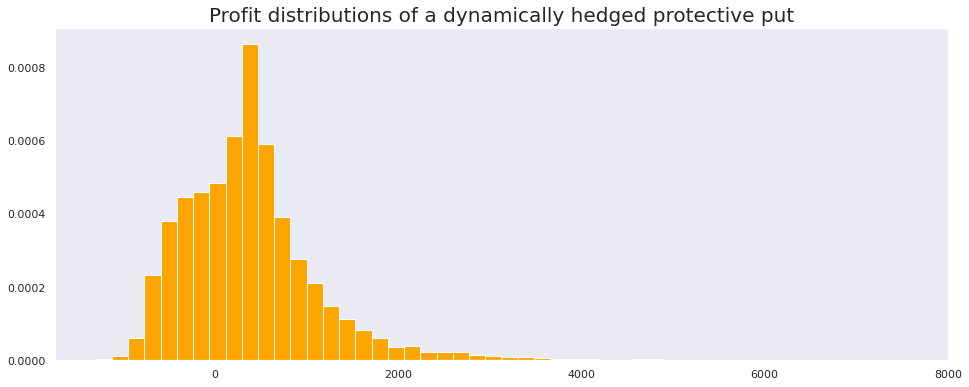

In [9]:
# Initialize variables
asset_owned = 0
money_in = [50 * option_price for _ in range(10000)]  # Initial investment for the options
num_option_contracts = 0
position = {}

# Initialize positions with 100 puts and 0 assets for each simulation
position['number_puts'] = np.array([100 for _ in range(10000)])
position['number_assets'] = np.array([0 for _ in range(10000)])

# Loop through each time step
for i in range(N):
    time_to_exp = TTE[i]
    asset_prices = A[i]  # Asset values at the current time step
    
    # Calculate put option prices for each asset price
    put_bs_price = np.array([bs('p', x, K, time_to_exp, 0, sigma) for x in asset_prices])
    
    # Calculate put option values (negative payoffs)
    B = np.maximum(-A[i] + K, 0)
    
    # Calculate deltas for the puts and adjust with the existing asset positions
    Deltas = np.array([calc_delta('p', price, K, time_to_exp, 0, sigma, position='l') for price in asset_prices]) + np.array(position['number_assets'])
    
    # Update the number of puts and assets based on deltas
    position['number_puts'] += np.maximum(Deltas, 0)
    position['number_assets'] += np.maximum(-Deltas, 0)
    
    # Calculate the total money spent for puts and assets at the current time step
    money_in += (put_bs_price * np.maximum(Deltas, 0) + A[i] * np.maximum(-Deltas, 0)) * np.exp(-r * T)

# Calculate the final position values
final_position_values = position['number_puts'] * np.maximum(-(A[-1] - K), 0) + position['number_assets'] * A[-1]

# Plot the profit distribution
plt.hist(final_position_values - money_in, density=True, bins=50, color='orange')
plt.title('Profit distributions of a dynamically hedged protective put', size=20)
plt.show()


In [10]:
print(f'The expected return of dynamically hedged protective put: {round(np.mean(100*(final_position_values-money_in)/money_in)-1,2)}%')
print('------')
print(f'The average amount of capital invested in dynamic strategy ${round(np.mean(money_in),2)}')
print('----------------------')

The expected return of dynamically hedged protective put: 3.26%
------
The average amount of capital invested in dynamic strategy $8355.62
----------------------


The true value of delta hedging becomes apparent when there are underpriced put contracts on the market. We will rerun the previous example, but we will price the options for a volatility of .2, instead of .3, and observe that the distributions of profits is quite favorable to the trader.

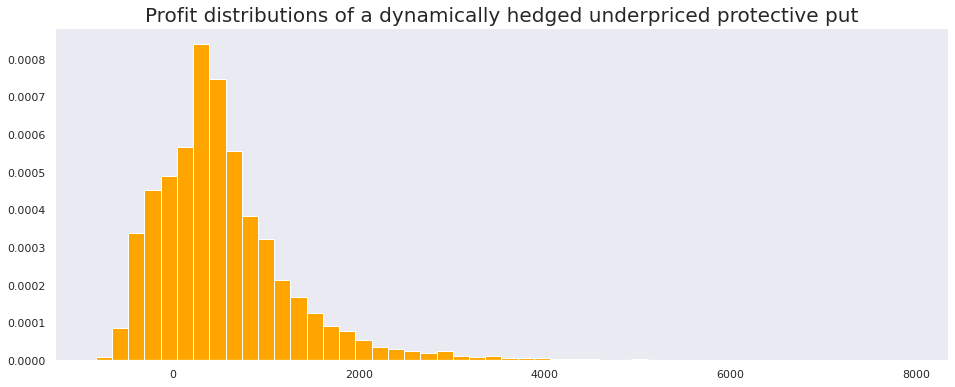

In [11]:
# Initialize variables
asset_owned = 0
money_in = [50 * option_price for _ in range(10000)]  # Initial investment for the options
money_out = [0 for _ in range(10000)]  # Initial money out for the options
num_option_contracts = 0
position = {}

# Initialize positions with 100 puts and 0 assets for each simulation
position['number_puts'] = np.array([100 for _ in range(10000)])
position['number_assets'] = np.array([0 for _ in range(10000)])

# Loop through each time step
for i in range(N):
    time_to_exp = TTE[i]
    asset_prices = A[i]  # Asset values at the current time step
    
    # Calculate put option prices for each asset price
    put_bs_price = np.array([bs('p', x, K, time_to_exp, 0, 0.2) for x in asset_prices])
    
    # Calculate put option values (negative payoffs)
    B = np.maximum(-A[i] + K, 0)
    
    # Calculate deltas for the puts and adjust with the existing asset positions
    Deltas = np.array([calc_delta('p', price, K, time_to_exp, 0, 0.3, position='l') for price in asset_prices]) + np.array(position['number_assets'])
    
    # Update the number of puts and assets based on deltas
    position['number_puts'] += np.maximum(Deltas, 0)
    position['number_assets'] += np.maximum(-Deltas, 0)
    
    # Calculate the total money spent for puts and assets at the current time step
    money_in += (put_bs_price * np.maximum(Deltas, 0) + A[i] * np.maximum(-Deltas, 0)) * np.exp(-r * T)
    
# Calculate the final position values
final_position_values = position['number_puts'] * np.maximum(-(A[-1] - K), 0) + position['number_assets'] * A[-1]

# Plot the profit distribution
plt.hist(final_position_values - money_in, density=True, bins=50, color='orange')
plt.title('Profit distributions of a dynamically hedged underpriced protective put', size=20)
plt.show()


In [12]:
print(f'The expected return of dynamically hedged position on underpriced protective put: {round(np.mean(100*(final_position_values-money_in)/money_in)-1,2)}%')
print('---------------------------------------')

The expected return of dynamically hedged position on underpriced protective put: 5.67%
---------------------------------------


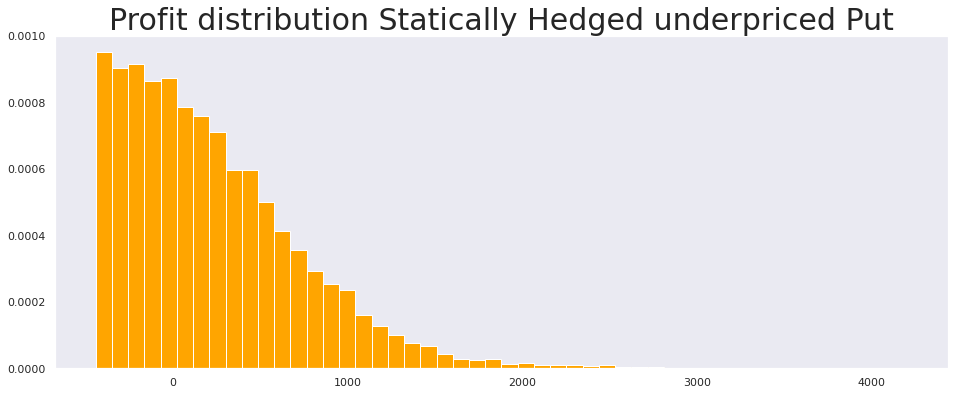

In [13]:
# Calculate the initial option price for a protective put
option_price = bs('p', K, K, T, r, 0.2)

# Calculate the put values and subtract the option price to get B
B = np.maximum(-(A[-1] - K), 0) - option_price

# Calculate the final position values (C) considering both the put values (B) and asset values
C = 100 * B + 50 * (A[-1] - K)

# Calculate the total money spent for the protective put and assets
money_in = 100 * option_price + 50 * K

# Plot the profit distribution for the statically hedged underpriced put
plt.hist(C, density=True, bins=50, color='orange')
plt.title('Profit distribution Statically Hedged underpriced Put', size=30)
plt.show()


In [14]:
print(f'The expected return of statically hedged position of underpriced puts {round(np.mean(100*(B)/option_price)-1,2)}%')

The expected return of statically hedged position of underpriced puts 51.13%


The returns on an undervalued put are enormous relevant to the investment. However, so are the losses if we overpay for the put as seen below.

Now suppose that market prices for an option are overpriced to the future realized volatility of the stock. Then even if we dynamically hedge, we should not expect favorable outcomes. However, we will see that dynamically hedging, as opposed to a static hedge, will still produce more favorable outcomes as it greatly reduces the losses of a portfolio on a dynamically hedged position.

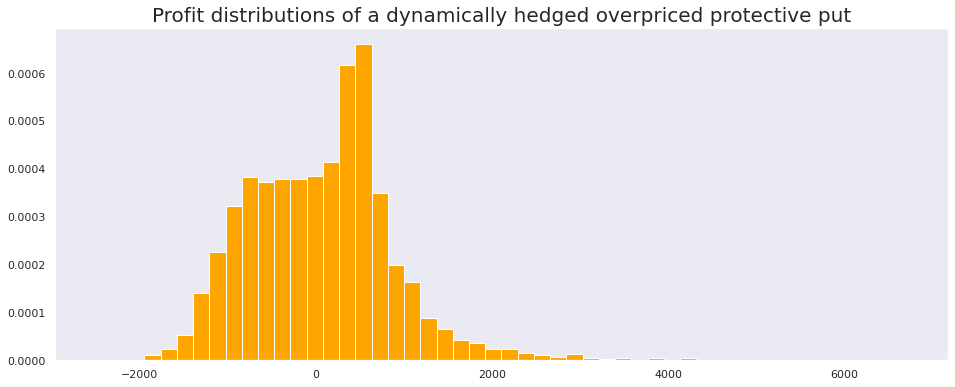

In [15]:
# Initialize variables
asset_owned = 0
money_in = [50 * option_price for i in range(10000)]
money_out = [0 for i in range(10000)]
num_option_contracts = 0
position = {}

# Initialize the number of put contracts and assets for each simulation
position['number_puts'] = np.array([100 for i in range(10000)])
position['number_assets'] = np.array([0 for i in range(10000)])

# Iterate over time steps
for i in range(N):
    # Calculate time to expiration for the current step
    time_to_exp = TTE[i]
    
    # Get asset prices for the current step
    asset_prices = A[i]
    
    # Calculate put prices using Black-Scholes formula
    put_bs_price = np.array([bs('p', x, K, time_to_exp, 0, 0.5) for x in asset_prices])
    
    # Calculate put values (B) based on asset prices and strike price
    B = np.maximum(-A[i] + K, 0)
    
    # Calculate option deltas for each asset price
    Deltas = np.array([calc_delta('p', price, K, time_to_exp, 0, sigma, position='l') for price in asset_prices]) + np.array(position['number_assets'])
    
    # Update the number of put contracts and assets based on deltas
    position['number_puts'] += np.maximum(Deltas, 0)
    position['number_assets'] += np.maximum(-Deltas, 0)
    
    # Update money_in based on put option payouts and asset values
    money_in += (put_bs_price * np.maximum(Deltas, 0) + A[i] * np.maximum(-Deltas, 0)) * np.exp(-r * T)

# Calculate final position values
final_position_values = position['number_puts'] * np.maximum(-(A[-1] - K), 0) + position['number_assets'] * A[-1]

# Plot the profit distribution of the dynamically hedged overpriced protective put strategy
plt.hist(final_position_values - money_in, density=True, bins=50,color='orange')
plt.title('Profit distributions of a dynamically hedged overpriced protective put', size=20)
plt.show()


In [16]:
print(f'The expected return of dynamically hedged position of overpriced puts {round(np.mean(100*(final_position_values-money_in)/money_in)-1,2)}%')
print('-----------------------------------------')

The expected return of dynamically hedged position of overpriced puts -1.09%
-----------------------------------------


A loss of around 1-2% is not devistating to an investor a trader. But losses incurred from not hedging at all can be tremendous.

### Important Takeaway

Dynamically hedging reduces losses and profits when options are bought (or sold) at mismatched prices. The tradeoff for not being able to enjoy as potentially great of profits is that when options are bought at fair market value, dynamically hedging them will produce consistent profits. Such a strategy is inheritly less risky and profits (and losses) can then increased by applying leverage to your positions. Over time, the consistent level of returns scaled by leverage can produce relatively low risk strategies with large profit margins.


Dynamic hedging through via purchasing puts and stock can require tremendous capital to start. Option contracts are sold in multiples of $100$ and an initial hedge will require a purchase of $50$ of the underlying stock. Only being able to buy In our example, the average amount of capital needed was slightly above $\$6000$. 

**Caution**

The dynamically hedged positions above are highly unrealistic and only serve as educational material. Option contracts are typically bought, sold, and executed in multiples of $100$. 